In [17]:
import torch
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import torchvision
from torchvision.transforms import v2

from app.models import ONet
from app.utils import seed_everything
from app.utils_dataset import create_df, get_data, get_data_loaders
from app.utils_model import train, model_inference, test_dlib
from app.utils_plot import plot_ced_auc_test, plot_CED_AUC_compare
import app.settings as settings

In [3]:
seed_everything(settings.RANDOM_STATE)

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

train_df, val_df, test_df = get_data(settings.IMAGE_DIRS_TRAIN, settings.IMAGE_DIRS_MENPO_TEST, use_val_dataset=True)
train_loader, val_loader, test_loader = get_data_loaders(train_df, val_df, test_df)

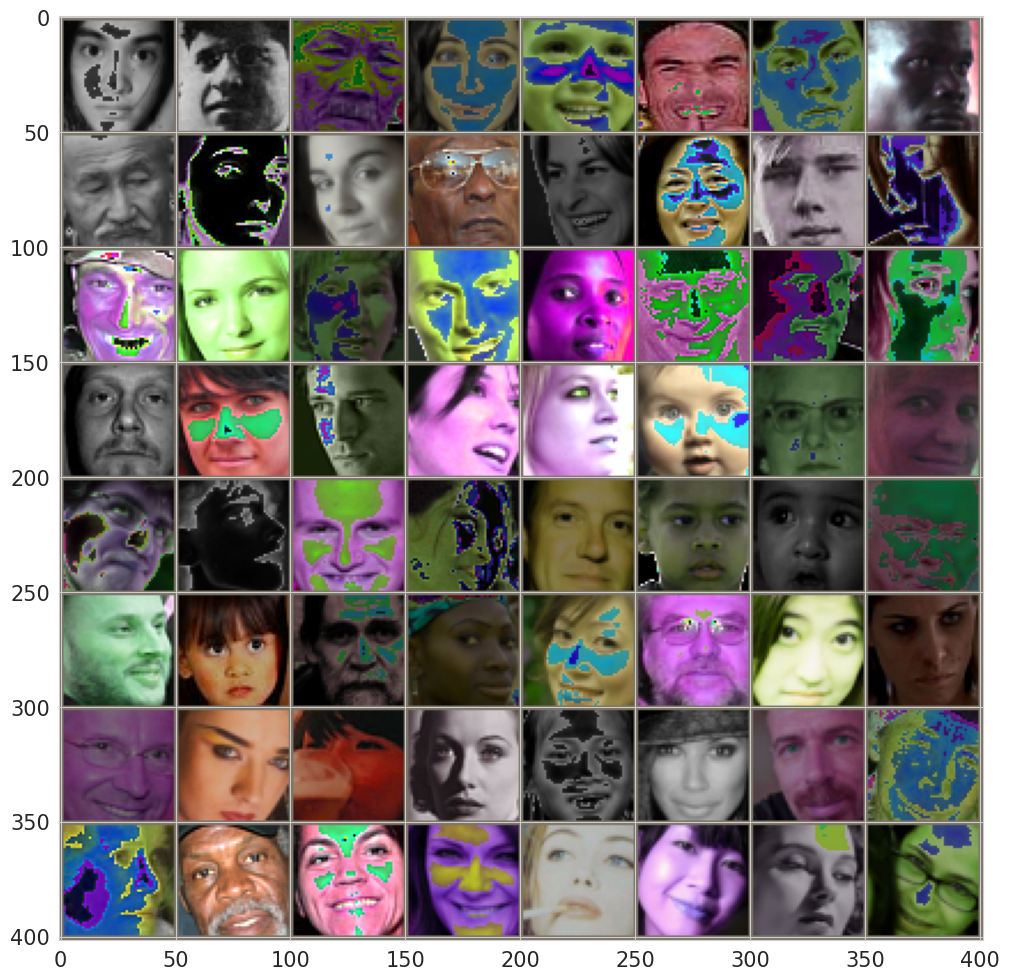

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
images, real_landmarks, resized_landmarks, rect = next(iter(train_loader))
# cv2.rectangle(image, (rect[0],rect[1]), (rect[2],rect[3]), (255, 0, 0), 2)
# for i in real_landmarks:
#     image = cv2.circle(image, i, radius=0, color=(0, 0, 255), thickness=-1)
# Расположим картинки рядом
out = torchvision.utils.make_grid(images)

imshow(out)

Обучение модели( Пока что возьмем O-Net)

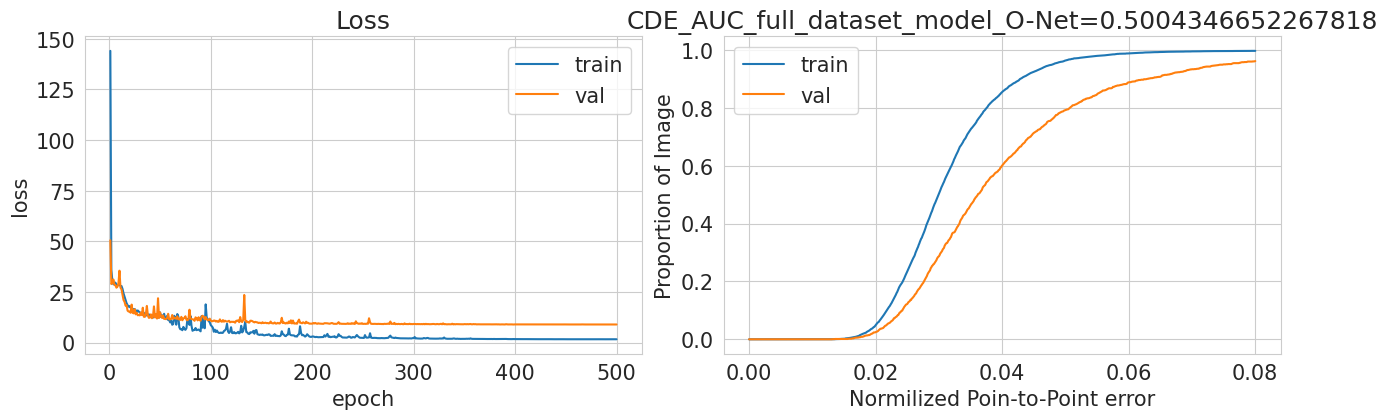

epoch 500,

                train_losses: 1.6321,

                val_losses: 8.9363,
 
                common_train_auc_0_08: 0.6064,
 
                common_val_auc_0_08: 0.5004,

                lr: 0.0


AttributeError: module 'app.settings' has no attribute 'STUDY_MODEL_WEIGHT'

In [6]:
import os

model = ONet()
model = model.to(settings.DEVICE)

NAME = 'full_dataset_model_O-Net'
STATE_FILE = f'{settings.STUDY_MODEL_WEIGHTS}/{NAME}.pth'
num_epochs = 500

if not os.path.exists(STATE_FILE):
    # В качестве cost function используем кросс-энтропию
    criterion = torch.nn.MSELoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        # weight_decay=2e-05
    )

    # scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)


    train_losses, val_losses, common_train_auc_0_08, common_val_auc_0_08, common_train_RMSE, common_val_RMSE = train(
        model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, NAME
    )

    # создаем словать из того что хотим сохранить
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': train_losses[-1],
        'common_train_auc_0_08': common_train_auc_0_08[-1],
        'common_val_auc_0_08': common_val_auc_0_08[-1],
        'common_train_RMSE': common_train_RMSE[-1],
        'common_val_RMSE': common_val_RMSE[-1],
    }
    torch.save(state, STATE_FILE)
else:
    state = torch.load(STATE_FILE)
    model.load_state_dict(state['state_dict'])


Получим результаты для тестовой части Menpo , модель ONet_full

In [22]:
import os
import pickle

train_df, val_df, test_df = get_data(settings.IMAGE_DIRS_TRAIN, settings.IMAGE_DIRS_MENPO_TEST, use_val_dataset=True)
train_loader, val_loader, test_loader = get_data_loaders(train_df, val_df, test_df)

RMSE_Menpo, test_auc_0_08_Menpo, pred_landmarks_model_Menpo = model_inference(model, test_loader, tqdm_desc='model_inference')
data_result= {
     'RMSE': RMSE_Menpo, 
     'test_auc_0_08': test_auc_0_08_Menpo, 
     'pred_landmarks_model': pred_landmarks_model_Menpo
}

PREDICTIONS_FILE = f'{settings.ROOT_DIR}/results/predictions_Menpo_ONet_full.pkl'
if os.path.exists(PREDICTIONS_FILE):
      os.remove(PREDICTIONS_FILE)
      
with open(PREDICTIONS_FILE, 'wb') as fp:
    pickle.dump(data_result, fp)


model_inference:   0%|          | 0/11 [00:00<?, ?it/s]

Получим результаты для тестовой части 300W, модель ONet_full

In [19]:
train_df, val_df, test_df = get_data(settings.IMAGE_DIRS_TRAIN, settings.IMAGE_DIRS_300W_TEST, use_val_dataset=True)
train_loader, val_loader, test_loader = get_data_loaders(train_df, val_df, test_df)

RMSE_300W, test_auc_0_08_300W, pred_landmarks_model_300W = model_inference(model, test_loader, tqdm_desc='model_inference')
data_result= {
     'RMSE': RMSE_300W, 
     'test_auc_0_08': test_auc_0_08_300W, 
     'pred_landmarks_model': pred_landmarks_model_300W
}

PREDICTIONS_FILE = f'{settings.ROOT_DIR}/results/predictions_300W_ONet_full.pkl'
if os.path.exists(PREDICTIONS_FILE):
      os.remove(PREDICTIONS_FILE)
      
with open(PREDICTIONS_FILE, 'wb') as fp:
    pickle.dump(data_result, fp)

model_inference:   0%|          | 0/6 [00:00<?, ?it/s]

Результаты DLIB model На тесте - 300W

In [14]:
PREDICTIONS_FILE = f'{settings.ROOT_DIR}/results/predictions_300W_DLIB.pkl'

if not os.path.exists(PREDICTIONS_FILE):
      test_df = create_df(settings.IMAGE_DIRS_300W_TEST)
      ced_auc_0_08_300W_dlib, RMSE_300W_test_dlib, pred_landmarks_300W_dlib  = test_dlib(test_df)
      result_model_300W_DLIB_inference = {'RMSE': RMSE_300W_test_dlib, 'test_auc_0_08': ced_auc_0_08_300W_dlib, 'pred_landmarks_model': pred_landmarks_300W_dlib}
      with open(PREDICTIONS_FILE, 'wb') as fp:
            pickle.dump(result_model_300W_DLIB_inference, fp)
else:
      with open(PREDICTIONS_FILE, 'rb') as fp:
            result_model_300W_DLIB_inference = pickle.load(fp)
      RMSE_300W_test_dlib = result_model_300W_DLIB_inference['RMSE']
      ced_auc_0_08_300W_dlib = result_model_300W_DLIB_inference['test_auc_0_08']
      pred_landmarks_300W_dlib = result_model_300W_DLIB_inference['pred_landmarks_model']

Результаты DLIB model На тесте - Menpo

In [15]:
PREDICTIONS_FILE = f'{settings.ROOT_DIR}/results/predictions_Menpo_DLIB.pkl'

if not os.path.exists(PREDICTIONS_FILE):
      test_df = create_df(settings.IMAGE_DIRS_MENPO_TEST)
      ced_auc_0_08_Menpo_dlib, RMSE_Menpo_test_dlib, pred_landmarks_Menpo_dlib  = test_dlib(test_df)
      result_model_Menpo_DLIB_inference = {'RMSE': RMSE_Menpo_test_dlib, 'test_auc_0_08': ced_auc_0_08_Menpo_dlib, 'pred_landmarks_model': pred_landmarks_Menpo_dlib}
      with open(PREDICTIONS_FILE, 'wb') as fp:
            pickle.dump(result_model_Menpo_DLIB_inference, fp)
else:
      with open(PREDICTIONS_FILE, 'rb') as fp:
            result_model_Menpo_DLIB_inference = pickle.load(fp)
      RMSE_Menpo_test_dlib = result_model_Menpo_DLIB_inference['RMSE']
      ced_auc_0_08_Menpo_dlib = result_model_Menpo_DLIB_inference['test_auc_0_08']
      pred_landmarks_Menpo_dlib = result_model_Menpo_DLIB_inference['pred_landmarks_model']

  0%|          | 0/657 [00:00<?, ?it/s]

RMSE_dlib [0.01041269 0.01120455 0.01227409 0.01315996 0.01317899 0.01322656
 0.01324625 0.01328855 0.01348651 0.01349364 0.01352207 0.01366827
 0.01371477 0.0138464  0.01388083 0.01412381 0.01414654 0.01433276
 0.01434325 0.01440255 0.01449972 0.01451932 0.01471518 0.01477614
 0.0147891  0.01513073 0.01515197 0.01517361 0.01530382 0.01531369
 0.01535031 0.01542506 0.01554852 0.01569728 0.01575775 0.01590606
 0.01596614 0.01609544 0.01609764 0.01610728 0.01619981 0.0162133
 0.01624533 0.01624603 0.01632705 0.01645722 0.01666886 0.01673851
 0.01688461 0.01690399 0.01696828 0.01697466 0.01701246 0.0170438
 0.01711609 0.01719694 0.01739755 0.01740784 0.01755086 0.01760852
 0.01763073 0.01764144 0.01766274 0.01771252 0.01778351 0.0179069
 0.01791729 0.01809459 0.01823803 0.01833418 0.01843988 0.01847277
 0.01849665 0.01850253 0.01852106 0.01859499 0.01864729 0.01865534
 0.01875342 0.01886029 0.01887048 0.01887842 0.0189443  0.01909863
 0.01912807 0.01915605 0.01924664 0.01925648 0.01927486

Построим графики для каждого тествого датасета и сравним модели.

Датасет 300W

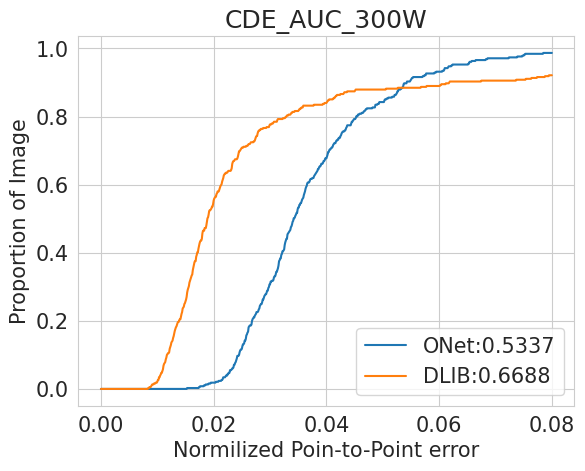

In [20]:
plot_CED_AUC_compare(
    RMSE_model=RMSE_300W ,
    auc_model=test_auc_0_08_300W,
    RMSE_dlib=RMSE_300W_test_dlib, 
    auc_dlib=ced_auc_0_08_300W_dlib,
    thres=0.08,
    step=0.0001,
    type_model='ONet',
    image_data='300W'
)

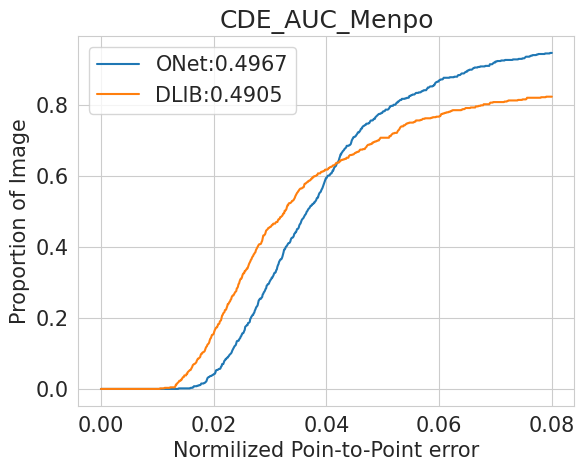

In [23]:
plot_CED_AUC_compare(
    RMSE_model=RMSE_Menpo ,
    auc_model=test_auc_0_08_Menpo,
    RMSE_dlib=RMSE_Menpo_test_dlib, 
    auc_dlib=ced_auc_0_08_Menpo_dlib,
    thres=0.08,
    step=0.0001,
    type_model='ONet',
    image_data='Menpo'
)